In [ ]:
# Installs
!pip install modAL-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
import random
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from modAL.models import ActiveLearner 
from modAL.models.learners import BayesianOptimizer
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import BayesianRidge

In [ ]:
# Functions
def regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

In [ ]:
# Get the data
X, y = load_diabetes(return_X_y=True)
print(X.shape, y.shape)

(442, 10) (442,)


In [ ]:
# Split to test and pool sets
X_pool, y_pool = X[:X.shape[0]//2,:], y[:y.shape[0]//2]
X_test, y_test = X[X.shape[0]//2:,:], y[y.shape[0]//2:]

n_initial = 50

# Create random initial indexes
initial_idx = np.random.choice(range(X_pool.shape[0]),
                               size=n_initial,
                               replace=False)

# Create initial features and targets
X_initial, y_initial = X_pool[initial_idx, :], y_pool[initial_idx]
X_pool, y_pool = np.delete(X_pool, initial_idx, axis=0), np.delete(y_pool, initial_idx, axis=0)

print(f"X_initial_shape = {X_initial.shape}, y_initial_shape = {y_initial.shape}")
print(f"X_pool_shape = {X_pool.shape}, y_pool_shape = {y_pool.shape}")
print(f"X_test_shape = {X_test.shape}, y_test_shape = {y_test.shape}")

X_initial_shape = (50, 10), y_initial_shape = (50,)
X_pool_shape = (171, 10), y_pool_shape = (171,)
X_test_shape = (221, 10), y_test_shape = (221,)


In [ ]:
# Define Active Learner
regressor = ActiveLearner(
    estimator=BayesianRidge(),
    query_strategy=regression_std,
    X_training=X_initial, 
    y_training=y_initial
)

In [ ]:
# *********** Active learning ***********
scores = [regressor.score(X_test, y_test)]
while X_pool.shape[0] > 0:
  # Get next sample from pool set and reshape it
  query_idx, query_instance = regressor.query(X_pool)
  query_instance = query_instance.reshape(1, -1)

  # Update the model
  regressor.teach(query_instance, np.array([y_pool[query_idx]]))

  # Remove item from pool
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)

  # Update scores list
  scores.append(regressor.score(X_test, y_test))

In [ ]:
# *********** Random sampling ***********

# Create pool set
X_pool_random, y_pool_random = X[:X.shape[0]//2,:], y[:y.shape[0]//2]

# Create random indexes out of the previous concatenation
random_idx = np.random.choice(range(X_pool_random.shape[0]), 
                              size=X_pool_random.shape[0], 
                              replace=False)

# Create, train and evaluate the model
model = BayesianRidge()
random_scores = []
for i in range(n_initial, len(random_idx)):
  model.fit(X_pool_random[random_idx[:i]], y_pool_random[random_idx[:i]])
  random_scores.append(model.score(X_test, y_test))

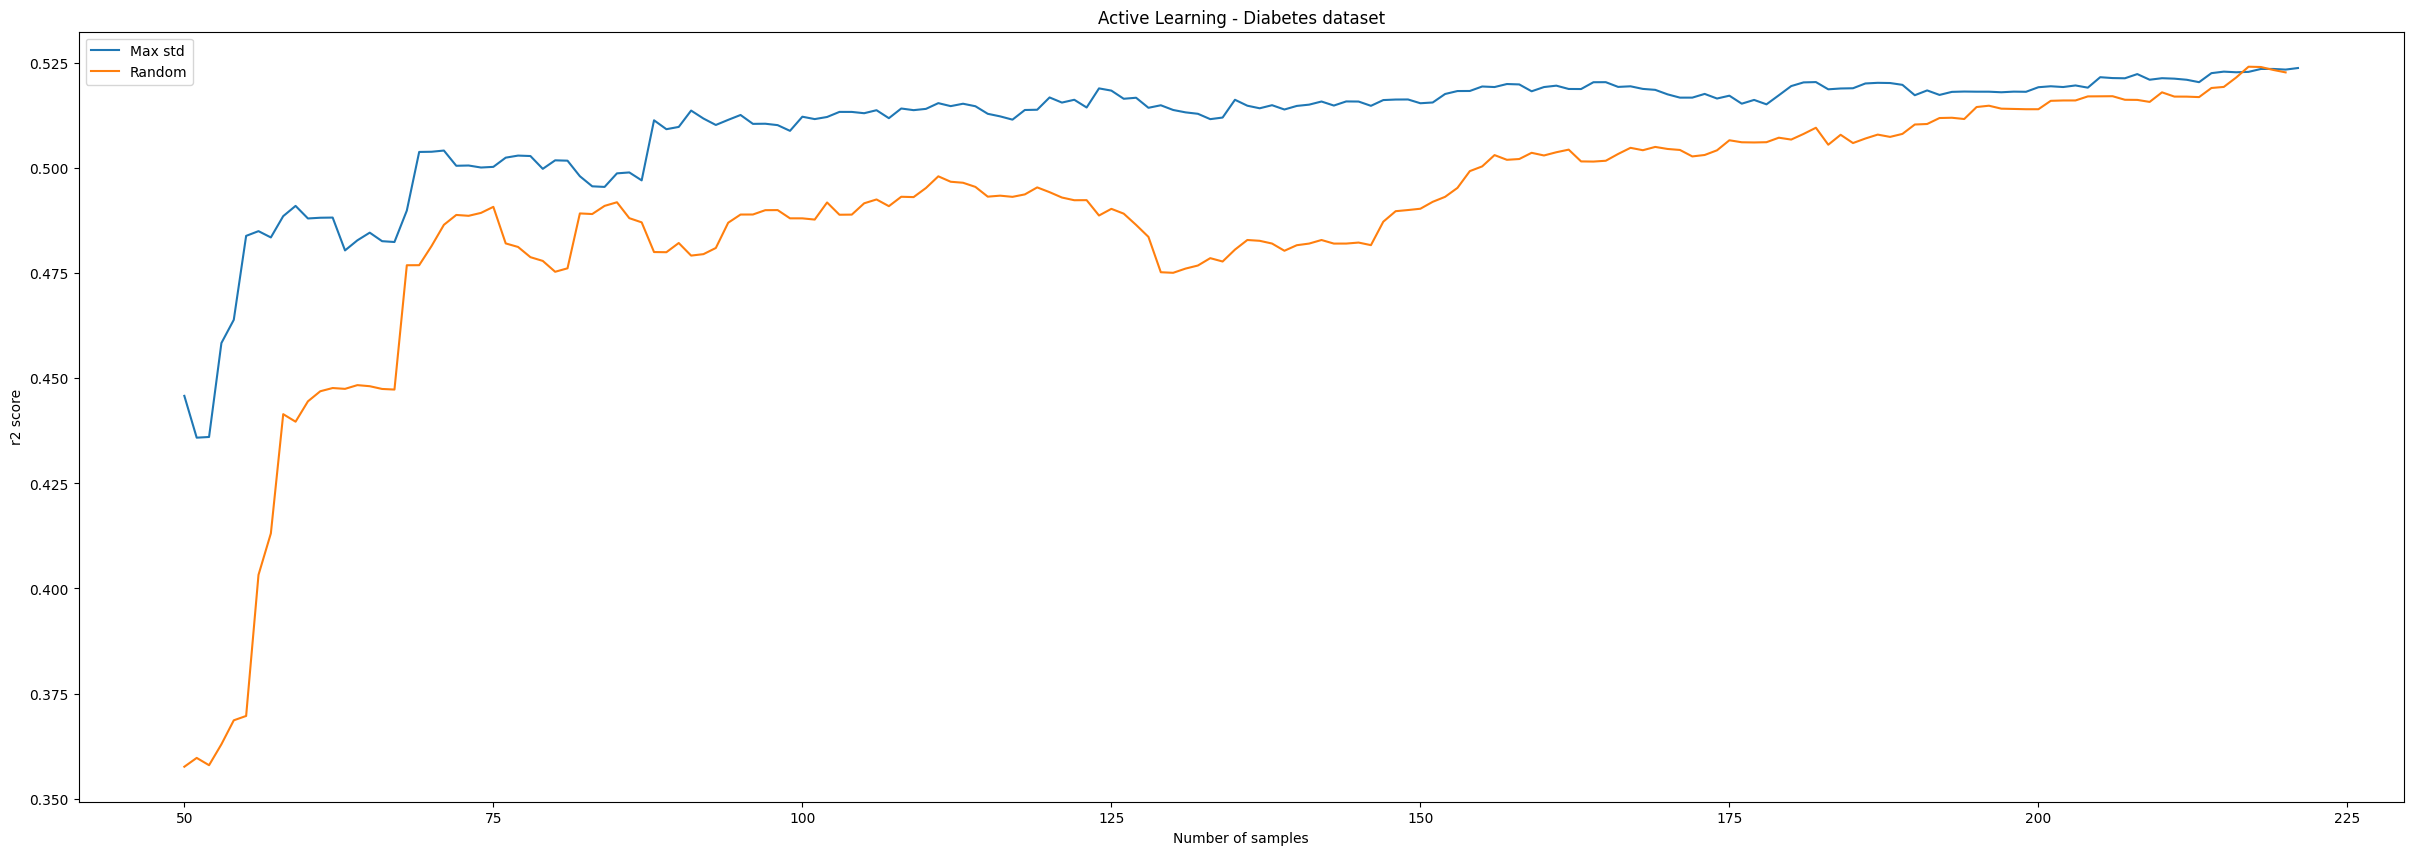

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(range(n_initial, n_initial + len(scores)), scores, label='Max std')
plt.plot(range(n_initial, n_initial + len(random_scores)), random_scores, label='Random')
plt.ylabel("r2 score")
plt.xlabel("Number of samples")
plt.title("Active Learning - Diabetes dataset")
plt.legend()
plt.show()

**Από το παραπάνω διάγραμμα παρατηρώ ότι η μέθοδος του Active Learning δίνει καλύτερα αποτελέσματα σε σχέση με την τυχαία επιλογή δεδομένων. Μόνο όταν ο  αριθμός των δεδομένων που έχει επιλεχθεί πλησιάζει τον αρχικό αριθμό δεδομένων τα αποτελέσματα των 2 μεθόδων φαίνεται να συγκλίνουν.**